In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns




In [5]:
num_samples = 1000

data = {
    "Loan_ID": [f"L-{i+1:05d}" for i in range(num_samples)],
    "Applicant_Age": np.random.randint(18, 65, size=num_samples),
    "Loan_Amount": np.random.randint(1000, 50000, size=num_samples),
    "Annual_Income": np.random.randint(30000, 120000, size=num_samples),
    "Credit_Score": np.random.randint(300, 850, size=num_samples),
    "Employment_Status": np.random.choice(["Employed", "Unemployed"], size=num_samples),
    "Loan_Purpose": np.random.choice(["Home", "Car", "Education", "Business"], size=num_samples),
    "Application_Date": pd.date_range(start="2022-01-01", periods=num_samples, freq='D'),
}

# Introduce some fraud cases
data["fraud"] = np.where(
    (data["Applicant_Age"] > 50) & 
    (data["Loan_Amount"] > 30000) & 
    (data["Credit_Score"] < 600), 
    1,  # Fraudulent
    0   # Not Fraudulent
)

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv("loan_data.csv", index=False)

print("loan_data.csv has been created successfully!")

# Step 2: Load the dataset
df = pd.read_csv('loan_data.csv')

# Check for missing values
print(df.isnull().sum())

# Handling missing values (basic approach, may need more advanced handling based on the dataset)
df.fillna(df.median(), inplace=True)

# Encoding categorical features (Label Encoding for simplicity)
le = LabelEncoder()
df['Employment_Status'] = le.fit_transform(df['Employment_Status'])
df['Loan_Purpose'] = le.fit_transform(df['Loan_Purpose'])

# Separating features and target
X = df.drop(['Loan_ID', 'fraud', 'Application_Date'], axis=1)  # Exclude non-feature columns
y = df['fraud']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (Optional - for algorithms like XGBoost, scaling may not be necessary, but can still be applied)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

loan_data.csv has been created successfully!
Loan_ID              0
Applicant_Age        0
Loan_Amount          0
Annual_Income        0
Credit_Score         0
Employment_Status    0
Loan_Purpose         0
Application_Date     0
fraud                0
dtype: int64


/var/folders/_k/gr5ttry91tqbmk6mn27fh_5c0000gn/T/ipykernel_22292/650455525.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


       Applicant_Age   Loan_Amount  Annual_Income  Credit_Score  \
count    1000.000000   1000.000000    1000.000000   1000.000000   
mean       41.271000  25920.291000   74630.977000    565.372000   
std        13.391747  14192.591203   25963.688995    159.137696   
min        18.000000   1015.000000   30009.000000    300.000000   
25%        30.000000  13915.000000   52266.250000    427.000000   
50%        41.000000  26450.000000   73463.000000    556.000000   
75%        53.000000  38699.000000   97999.500000    710.000000   
max        64.000000  49908.000000  119948.000000    849.000000   

       Employment_Status  Loan_Purpose        fraud  
count        1000.000000   1000.000000  1000.000000  
mean            0.483000      1.526000     0.080000  
std             0.499961      1.119186     0.271429  
min             0.000000      0.000000     0.000000  
25%             0.000000      1.000000     0.000000  
50%             0.000000      2.000000     0.000000  
75%             1.

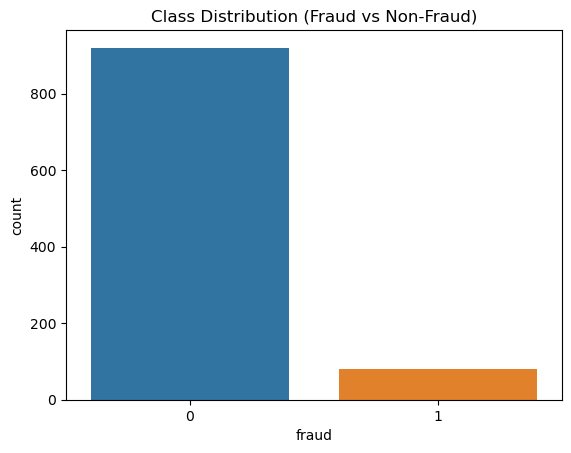

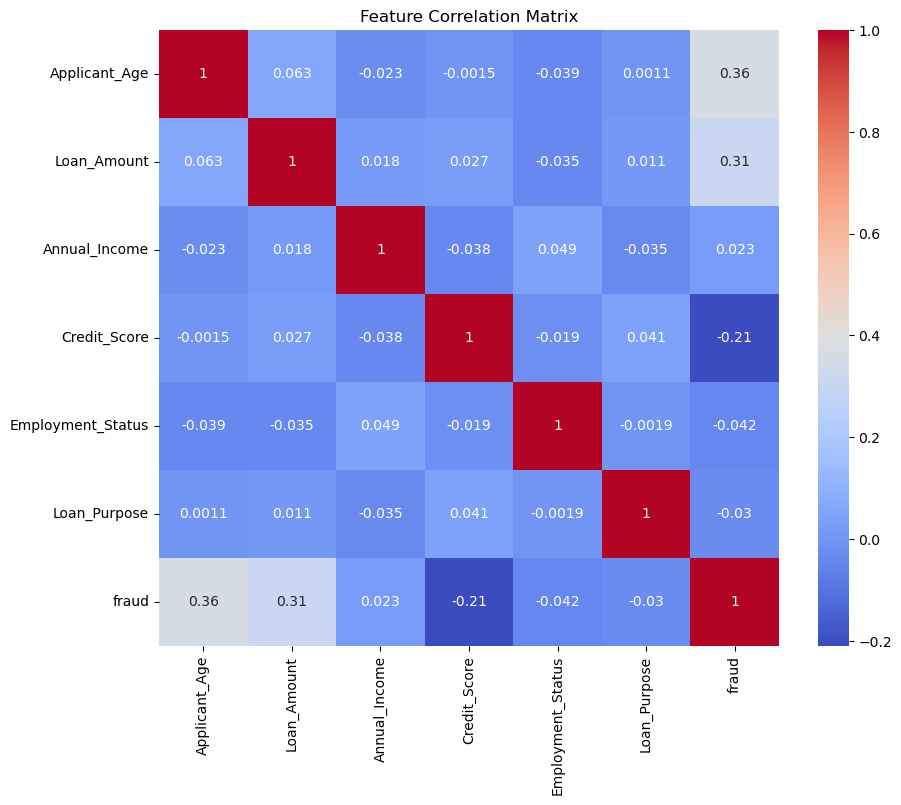

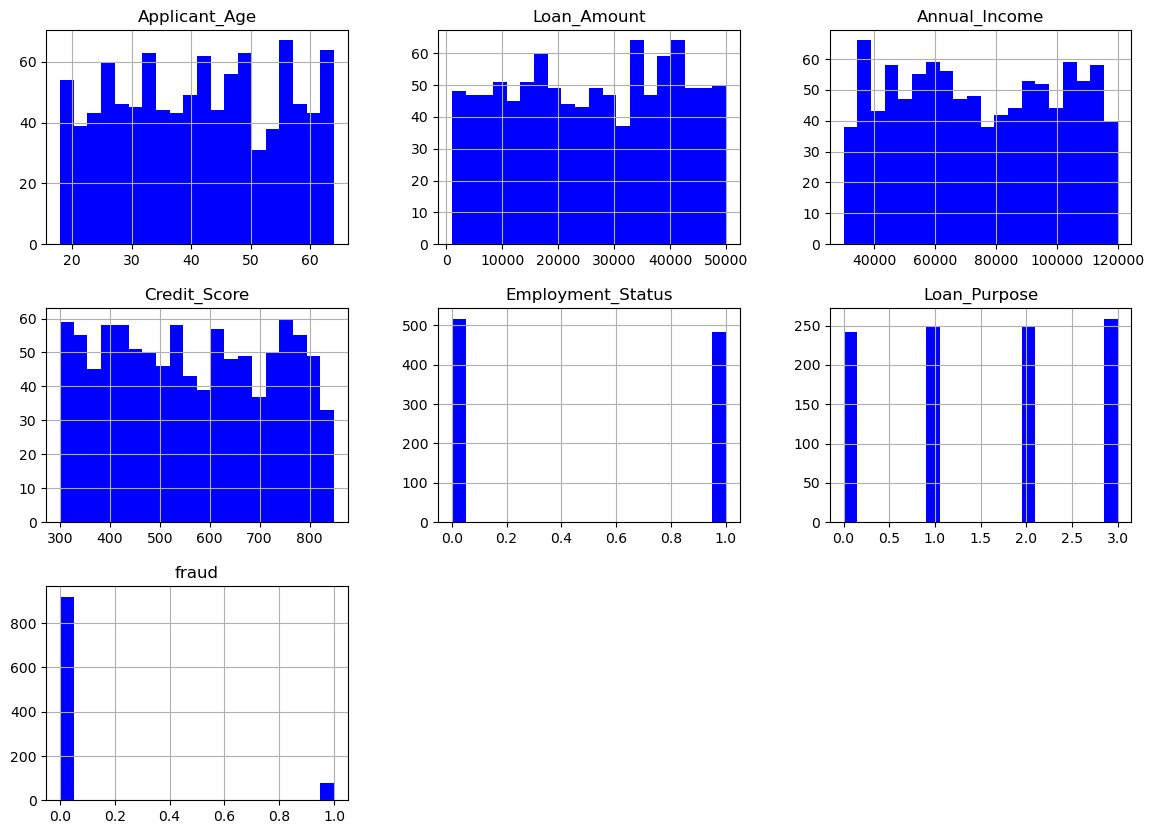

0    920
1     80
Name: fraud, dtype: int64


In [6]:
# EDA: Explore data distribution
print(df.describe())

# Plot class distribution (to check for class imbalance)
sns.countplot(x='fraud', data=df)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Plot feature distributions for numerical columns
df.hist(bins=20, figsize=(14,10), color='blue')
plt.show()

# Check for imbalance in the target class
fraud_count = df['fraud'].value_counts()
print(fraud_count)

# Handling class imbalance with oversampling/undersampling (if necessary)


In [7]:
# Convert the data into DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'  # Logarithmic loss for binary classification
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_prob = xgb_model.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]


[15:42:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849653518/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.



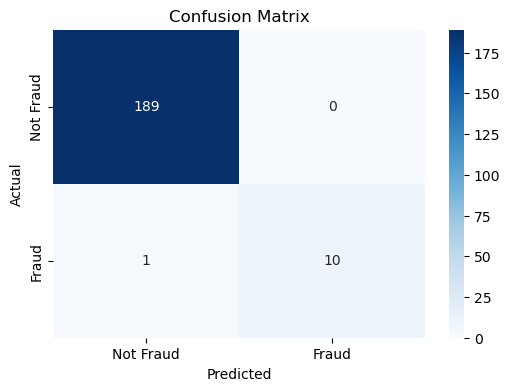

Precision: 1.0000
F1 Score: 0.9524
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       189
           1       1.00      0.91      0.95        11

    accuracy                           0.99       200
   macro avg       1.00      0.95      0.97       200
weighted avg       1.00      0.99      0.99       200



In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

# Precision Score
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


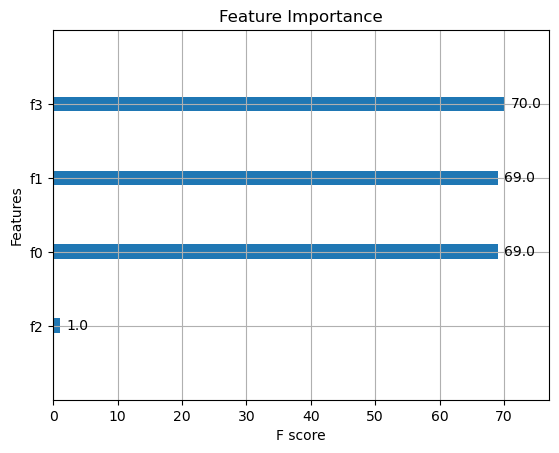

In [9]:
# Plotting feature importance
xgb.plot_importance(xgb_model)
plt.title('Feature Importance')
plt.show()
